In [677]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import scipy.stats as stats
%matplotlib inline

In [1044]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [679]:
def diagnostic_plot1(y, yhat):
    plt.figure(figsize=(20,5))
    
#     rgr = LinearRegression()
#     rgr.fit(x,y)
#     pred = rgr.predict(x)

#     plt.subplot(1, 3, 1)
#     plt.scatter(x,y)
#     plt.plot(x, pred, color='blue',linewidth=1)
#     plt.title("Regression fit")
#     plt.xlabel("x")
#     plt.ylabel("y")
    
    plt.subplot(1, 2, 1)
    res = y - yhat
    plt.scatter(yhat, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")

    plt.subplot(1, 2, 2)    
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    
    print(res.shape)
    print(res)
    
    stats.probplot(res.flat, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [680]:
#Load dataset
df = pd.read_csv('df/newdf.csv')


In [681]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5619 non-null   int64  
 1   draft_round       5619 non-null   int64  
 2   draft_pick        5619 non-null   int64  
 3   team              5619 non-null   object 
 4   player            5619 non-null   object 
 5   pos_x             5619 non-null   object 
 6   age               4819 non-null   float64
 7   year_max          4774 non-null   float64
 8   g                 4771 non-null   float64
 9   college_id        5614 non-null   object 
 10  player_link       2237 non-null   object 
 11  college_link      3570 non-null   object 
 12  year_x            5619 non-null   int64  
 13  playernametolink  5619 non-null   object 
 14  school_name       4491 non-null   object 
 15  pos_y             4493 non-null   object 
 16  height            4493 non-null   object 


In [682]:
#drop unneeded columns
todrop = ['Unnamed: 0', 'year_max', 'college_id', 'player_link', 'college_link',
         'year_x', 'playernametolink', 'player_link_x', 'player_link_y', 'year2',
         'cname_link', 'year_y', 'clink', 'plink', 'wonderlic','height']
df2 = df.drop(columns = todrop)


df2.rename(columns = {"height_in":"height"}, inplace =True)    
df2.rename(columns = {"pos_x":"position"}, inplace =True)  

df2.head()

,draft_round,draft_pick,team,player,position,age,g,school_name,pos_y,weight,...,vertical,broad_jump,shuttle,cone,height,DraftYr,conf,cname,cseasons,cgames
0,1,1,IND,Jeff George,QB,22.0,131.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,1990,Big Ten,Illinois,3.0,34.0
1,1,2,NYJ,Blair Thomas,RB,22.0,64.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,1990,Ind,Penn State,4.0,44.0
2,1,3,SEA,Cortez Kennedy,DT,22.0,167.0,Miami (FL),DT,295.0,...,NaN,NaN,9.99,9.99,0,1990,NaN,NaN,NaN,NaN
3,1,4,TAM,Keith McCants,DE,22.0,88.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,1990,SEC,Alabama,2.0,22.0
4,1,5,SDG,Junior Seau,LB,21.0,268.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,1990,Pac-10,USC,1.0,12.0


In [683]:
def combine_stats(obj):
    # Mean combine by position
    combine_events = 'cone broad_jump bench_reps vertical shuttle forty_yd'.split()
    combine_l = {}
    for evnt in combine_events:
        temp = obj[['position', evnt]].groupby('position')[evnt].mean()
        combine_l[evnt] = temp

    base = pd.DataFrame(combine_l).sort_values('forty_yd')

    combine_l2 = {}
    for evnt in combine_events:
        temp = obj[evnt].isna().sum()
        combine_l2[evnt] = temp

    summary1 = pd.DataFrame(combine_l2, index=['NA obs'])


    combine_l2 = {}
    for evnt in combine_events:
        temp = obj[evnt].notna().sum()
        combine_l2[evnt] = temp

    summary2 = pd.DataFrame(combine_l2, index=['non NA obs'])

    combinestats = pd.concat([base, summary1, summary2])

    positioncounts = pd.DataFrame(df2.position.value_counts())
    combinestats = pd.merge(combinestats, positioncounts, how = 'left', left_index = True, right_index= True)

    return combinestats

In [684]:
#combine_stats(df2)

In [685]:
df2.position.value_counts()

DB    1040
LB     737
WR     713
RB     506
DE     504
T      411
DT     407
TE     353
G      348
QB     273
C      148
FB      66
P       49
K       42
NT      21
KR       1
Name: position, dtype: int64

In [686]:
#df2.loc[df2.forty_yd == 9.99, "forty_yd"] = np.nan

In [687]:
df2.broad_jump.sort_values().head()

1980     7.0
1892     8.0
2269    83.0
5147    83.0
2674    86.0
Name: broad_jump, dtype: float64

In [726]:
df2.loc[df2.broad_jump == 7, "broad_jump"] = df2.broad_jump.mean()
df2.loc[df2.broad_jump == 8, "broad_jump"] = df2.broad_jump.mean()
df2.broad_jump.sort_values().head()

5147    83.0
2269    83.0
2674    86.0
579     87.0
2158    87.0
Name: broad_jump, dtype: float64

In [727]:
df2.describe(include='all')

,draft_round,draft_pick,team,player,position,age,g,school_name,pos_y,weight,...,height,DraftYr,conf,cname,cseasons,cgames,position_group,age_group,r1,r2
count,5619.000000,5619.000000,5619,5619,5619,5619.000000,4771.000000,5619,4493,5619.000000,...,5619.000000,5619.000000,5619,5619,5619.000000,5619.000000,5619,5619.000000,5619.000000,5619.000000
unique,NaN,NaN,35,5378,16,NaN,NaN,314,19,NaN,...,NaN,NaN,16,122,NaN,NaN,5,NaN,NaN,NaN
top,NaN,NaN,NWE,Kevin Williams,DB,NaN,NaN,NotAvailable,WR,NaN,...,NaN,NaN,NotAvailable,NotAvailable,NaN,NaN,Line,NaN,NaN,NaN
freq,NaN,NaN,210,18,1040,NaN,NaN,1128,576,NaN,...,NaN,NaN,2165,2165,NaN,NaN,2192,NaN,NaN,NaN
mean,4.619327,131.756718,NaN,NaN,NaN,22.596368,73.830434,NaN,NaN,241.658246,...,35.914059,1999.599039,NaN,NaN,3.038506,33.546902,NaN,0.987364,15.172807,15.172807
std,2.518947,78.947895,NaN,NaN,NaN,0.791572,57.901401,NaN,NaN,44.591402,...,32.261968,6.233610,NaN,NaN,0.816120,9.353029,NaN,0.111706,11.709350,11.010705
min,1.000000,1.000000,NaN,NaN,NaN,20.000000,0.000000,NaN,NaN,142.000000,...,8.216042,1990.000000,NaN,NaN,1.000000,1.000000,NaN,0.000000,1.000000,1.000000
25%,3.000000,64.000000,NaN,NaN,NaN,22.000000,23.000000,NaN,NaN,201.000000,...,8.498364,1994.000000,NaN,NaN,3.000000,33.000000,NaN,1.000000,6.000000,6.500000
50%,5.000000,130.000000,NaN,NaN,NaN,22.747024,63.000000,NaN,NaN,236.000000,...,8.833652,2000.000000,NaN,NaN,3.038506,33.546902,NaN,1.000000,12.500000,13.500000
75%,6.000000,196.000000,NaN,NaN,NaN,23.000000,115.000000,NaN,NaN,277.000000,...,73.000000,2005.000000,NaN,NaN,4.000000,38.000000,NaN,1.000000,21.500000,21.000000


In [792]:

df2.loc[df2['height'] == 0,"height"] = df2.groupby('position')['height'].mean().reset_index()

#r = df2.groupby('position')[['forty_yd']].mean()
cols = "age forty_yd bench_reps vertical broad_jump shuttle cone"

#clean up blanks converting na to means or median
for x in cols.split():
    print(x)
    df2.loc[df2[x] == 9.99, x] = df2.groupby('position')[x].transform('mean')
    #df2[x].fillna(df2.groupby(['position'])[x].median(), inplace=True)
    #df2[x].fillna(df2[x].median(), inplace=True)
    #. df2[x] = df2[x].fillna(df2.groupby('position')[x].transform(lambda x: x.fillna(x.mean())))
    # df2[x] = df2[x].fillna(df2[df2.position == ])
    #df2[x] = df[x == 9.99].replace({'9.99' : df.groupby(['pos_x'])[x].median()})
    #df2["forty_yd"] = df2['forty_yd'].fillna(df2.groupby('position')['forty_yd'].transform('mean'))
    df2[x] = df2[x].fillna(df2.groupby('position')[x].transform('mean'))
   
    #df2[x] = df2[x].fillna(df2[x].mean())


    #df2['forty_yd'] = df2.groupby('position')['forty_yd'].transform(lambda grp: grp.fillna(np.mean(grp)))
df2['conf'] = df2['conf'].fillna('NotAvailable')
df2['cname'] = df2['cname'].fillna('NotAvailable')
df2['school_name'] = df2['school_name'].fillna('NotAvailable')
df2['cseasons'] = df2['cseasons'].fillna(df2['cseasons'].mean())
df2['cgames'] = df2['cgames'].fillna(df2['cgames'].mean())
  
df2['weight'] = df2['weight'].fillna(df2.groupby('position')['weight'].transform('mean'))
df2['height'] = df2['height'].fillna(df2.groupby('position')['height'].transform('mean'))


df2['age'].fillna(df2.age.mean(), inplace= True)
df2['broad_jump'].fillna(df2.broad_jump.mean(), inplace= True)
df2['vertical'].fillna(df2.vertical.mean(), inplace= True)
df2['bench_reps'].fillna(df2.bench_reps.mean(), inplace= True)
df2['shuttle'].fillna(df2.shuttle.mean(), inplace= True)
df2['cone'].fillna(df2.cone.mean(), inplace= True)





df2.loc[df2['cone'] >= 9.0, 'cone'] = df2.cone.mean()
df2.loc[df2['shuttle'] >= 9.0, 'shuttle'] = df2.shuttle.mean()



age
forty_yd
bench_reps
vertical
broad_jump
shuttle
cone


In [796]:
df2.shuttle.isna().sum()


0

In [854]:
df2.draft_pick.value_counts()

17     35
19     29
206    28
159    28
205    28
       ..
331     2
333     2
332     2
334     1
335     1
Name: draft_pick, Length: 335, dtype: int64

<AxesSubplot:>

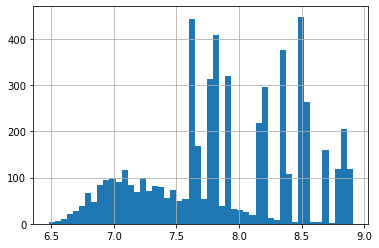

In [797]:
df2['cone'].hist(bins=50)

In [798]:
df2.isna().sum()

draft_round          0
draft_pick           0
team                 0
player               0
position             0
age                  0
g                  848
school_name          0
pos_y             1126
weight               0
forty_yd             0
bench_reps           0
vertical             0
broad_jump           0
shuttle              0
cone                 0
height               0
DraftYr              0
conf                 0
cname                0
cseasons             0
cgames               0
position_group       0
age_group            0
r1                   0
r2                   0
dtype: int64

In [730]:
df2['broad_jump'].fillna(10, inplace= True)

In [731]:
df2.vertical.mean()


32.71073491839764

In [732]:
df2.bench_reps.value_counts(dropna=False)

16.058824    645
14.712662    424
21.607843    278
22.692308    260
19.000000    241
19.243056    218
22.934426    199
18.000000    185
22.000000    184
24.000000    179
21.000000    178
23.000000    175
20.000000    171
25.000000    170
17.000000    167
25.067925    142
23.703297    138
26.000000    135
16.000000    134
20.313901    130
15.000000    125
27.000000     95
24.901575     94
28.000000     90
14.000000     86
13.000000     81
29.000000     66
12.000000     64
11.000000     61
10.000000     59
30.000000     55
17.500000     47
9.000000      46
25.038835     45
31.000000     43
32.000000     29
33.000000     29
34.000000     27
8.000000      24
35.000000     20
22.163265     17
7.000000      12
37.000000      9
36.000000      9
4.000000       4
6.000000       4
40.000000      3
3.000000       3
42.000000      2
45.000000      2
5.000000       2
2.000000       2
38.000000      2
44.000000      2
39.000000      2
41.000000      2
1.000000       1
43.000000      1
20.166840     

In [733]:
mapping = {'DB':'WR/DB',
           'LB':'Backs',
           'WR':'WR/DB',
           'RB':'Backs',
           'DE':'Line',
           'T':'Line',
           'DT':'Line',
           'TE':'Line',
           'G':'Line',
           'QB':'QB',
           'C':'Line',
           'FB':'Backs',
           'P':'Kicker',
           'K':'Kicker',
           'NT':'Line',
           'KR':'WR/DB'}

df2["position_group"] = df2.position.map(mapping)

In [941]:
df2.position_group.value_counts()

Line      2192
WR/DB     1754
Backs     1309
QB         273
Kicker      91
Name: position_group, dtype: int64

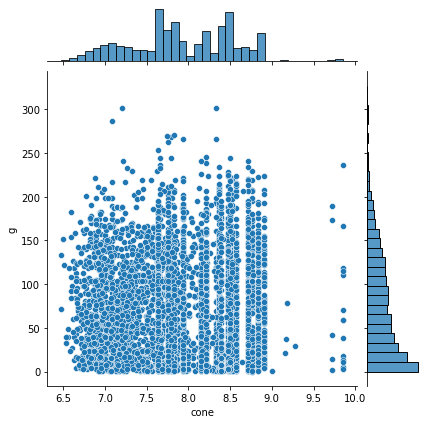

In [760]:
sns.jointplot(x = df2['cone'],y = df2['g'])

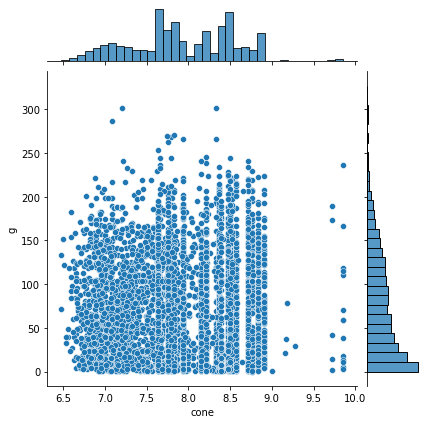

In [761]:
sns.jointplot(x = df2['cone'],y = df2['g'])

In [762]:
def setagegroup(x):
    temp = ""
    if x >= 25:
        temp = 0
    else:
        temp = 1
    return temp

df2["age_group"] = df2.age.map(setagegroup)

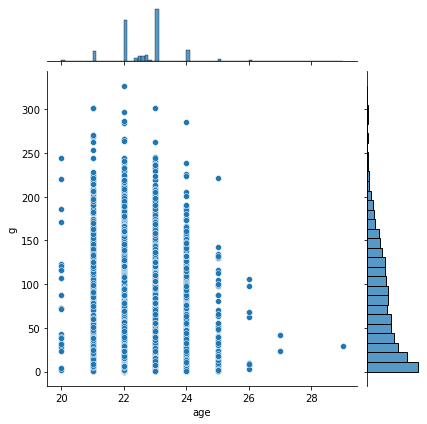

In [763]:
sns.jointplot(x = df2['age'],y = df2['g'])

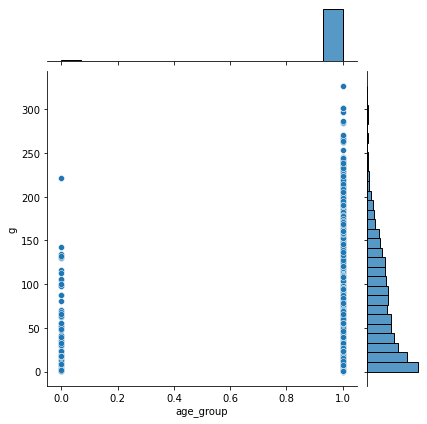

In [764]:
sns.jointplot(x = df2['age_group'],y = df2['g'])

In [765]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   draft_round     5619 non-null   int64  
 1   draft_pick      5619 non-null   int64  
 2   team            5619 non-null   object 
 3   player          5619 non-null   object 
 4   position        5619 non-null   object 
 5   age             5619 non-null   float64
 6   g               4771 non-null   float64
 7   school_name     5619 non-null   object 
 8   pos_y           4493 non-null   object 
 9   weight          5619 non-null   float64
 10  forty_yd        5619 non-null   float64
 11  bench_reps      5619 non-null   float64
 12  vertical        5619 non-null   float64
 13  broad_jump      5619 non-null   float64
 14  shuttle         5528 non-null   float64
 15  cone            5527 non-null   float64
 16  height          5619 non-null   float64
 17  DraftYr         5619 non-null   i

In [766]:
#df2.cname.fillna('NA', inplace=True)

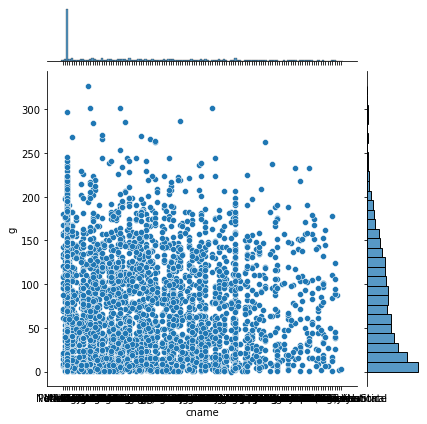

In [767]:
sns.jointplot(x = df2['cname'],y = df2['g'])

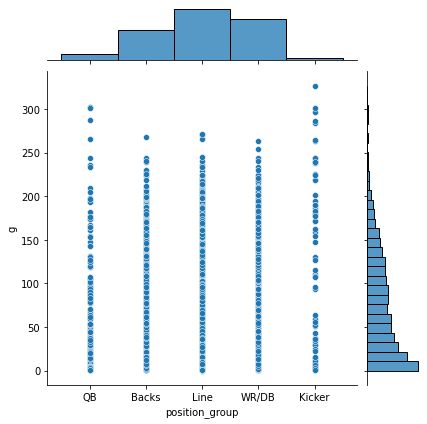

In [768]:
sns.jointplot(x = df2['position_group'],y = df2['g'])

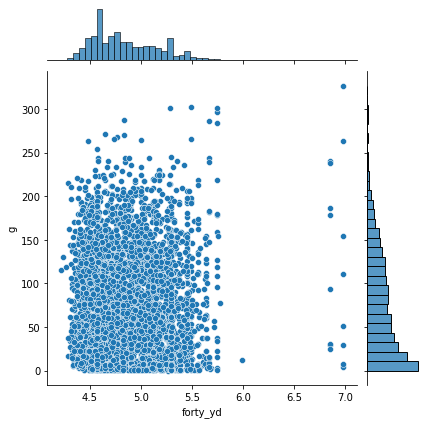

In [769]:
sns.jointplot(x = df2['forty_yd'],y = df2['g'])

In [770]:
df2[['draft_pick', 'DraftYr','position','forty_yd']].sort_values('forty_yd').tail()

,draft_pick,DraftYr,position,forty_yd
1290,202,1993,K,6.974545
1144,70,1993,K,6.974545
1187,113,1993,K,6.974545
1615,82,1995,K,6.974545
1040,315,1992,K,6.974545


In [771]:
df2.groupby(['DraftYr'])['forty_yd'].mean().sort_values()

DraftYr
2009    4.741025
2007    4.750184
2005    4.756826
2008    4.758249
2010    4.766852
2002    4.769359
2003    4.785870
2006    4.786226
2004    4.792512
2000    4.804263
2001    4.819199
1999    4.832023
1990    4.859472
1991    4.919715
1998    4.931653
1993    4.934698
1996    4.939882
1997    4.947396
1992    4.956503
1994    4.972085
1995    5.010448
Name: forty_yd, dtype: float64

In [709]:
df2['r1'] = df2.groupby(['DraftYr','position'])['forty_yd'].transform('rank')
df2['r2'] = df2.groupby(['DraftYr','position'])['bench_reps'].transform('rank')

In [710]:
df2[['forty_yd','r1','bench_reps', 'r2']]

,forty_yd,r1,bench_reps,r2
0,4.923884,8.5,22.692308,10.5
1,4.721990,21.5,19.243056,25.5
2,4.950000,3.0,23.000000,8.5
3,4.902930,13.5,22.934426,23.5
4,4.761812,25.5,21.607843,34.0
...,...,...,...,...
5614,4.680000,2.0,22.692308,7.5
5615,4.573463,39.0,14.712662,22.5
5616,4.761812,24.0,21.607843,9.0
5617,4.860000,17.0,22.934426,11.0


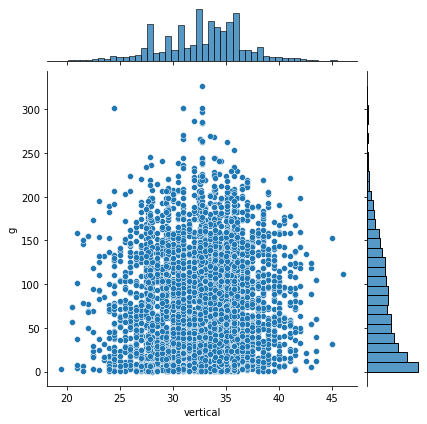

In [712]:
sns.jointplot(x = df2['vertical'],y = df2['g'])

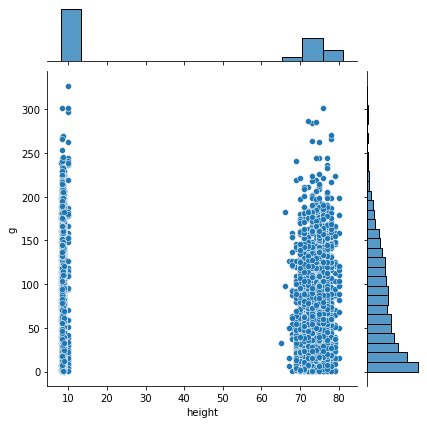

In [772]:
sns.jointplot(x = df2['height'],y = df2['g'])

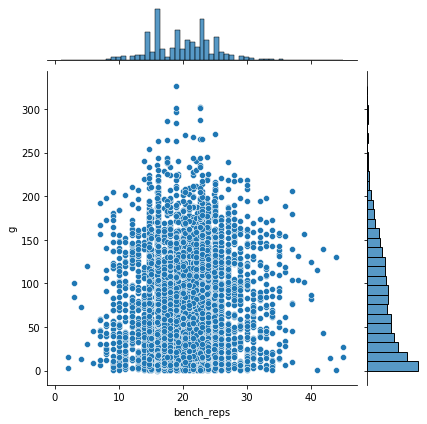

In [774]:
sns.jointplot(x = df2['bench_reps'],y = df2['g'])

In [720]:
df2.conf.unique()

array(['Big Ten', 'Ind', 'NotAvailable', 'SEC', 'Pac-10', 'SWC',
       'Big West', 'ACC', 'MAC', 'WAC', 'Big 8', 'Big East', 'Big 12',
       'CUSA', 'MWC', 'Sun Belt'], dtype=object)

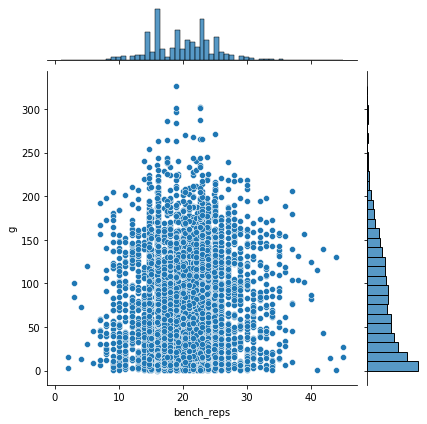

In [721]:
sns.jointplot(x = df2['bench_reps'],y = df2['g'])

In [722]:
df2.weight.value_counts(dropna = False)

196.698885    233
238.662116    151
196.138840    144
269.437500    104
217.218824     81
             ... 
366.000000      1
142.000000      1
160.000000      1
374.000000      1
162.000000      1
Name: weight, Length: 227, dtype: int64

In [723]:
df.weight.mean()

242.0930336078344

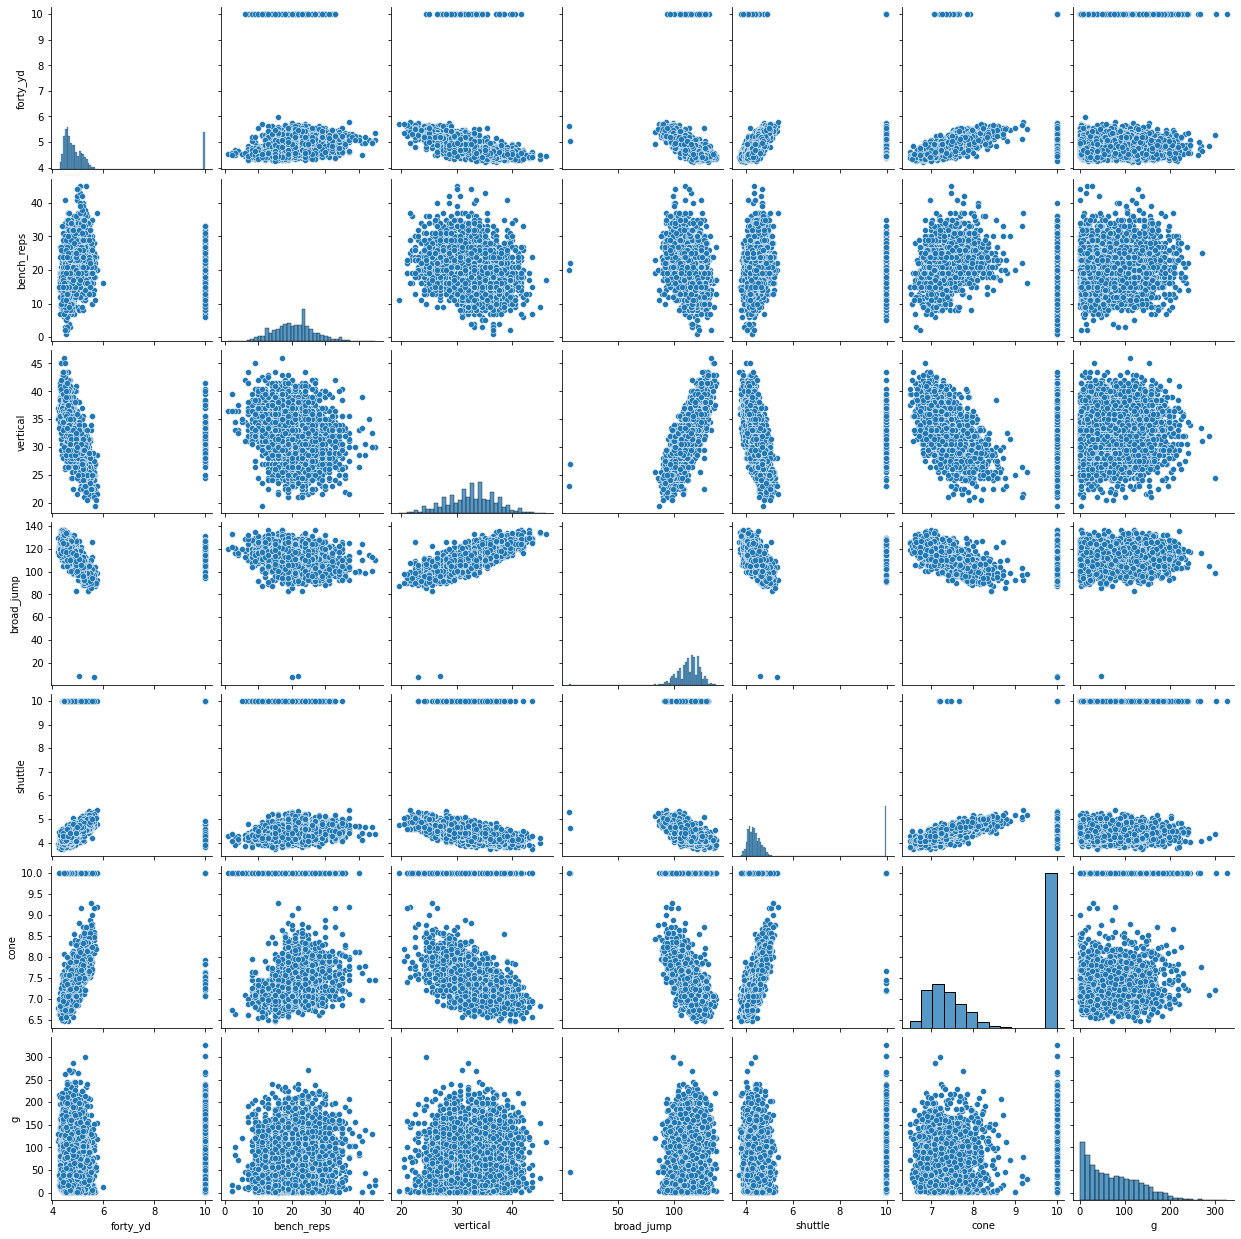

In [724]:
#Pairplot for combine scores - unadjusted
cols = ['forty_yd', 'bench_reps', 'vertical', 'broad_jump', 'shuttle', 'cone', 'g']
sns.pairplot(df[cols])

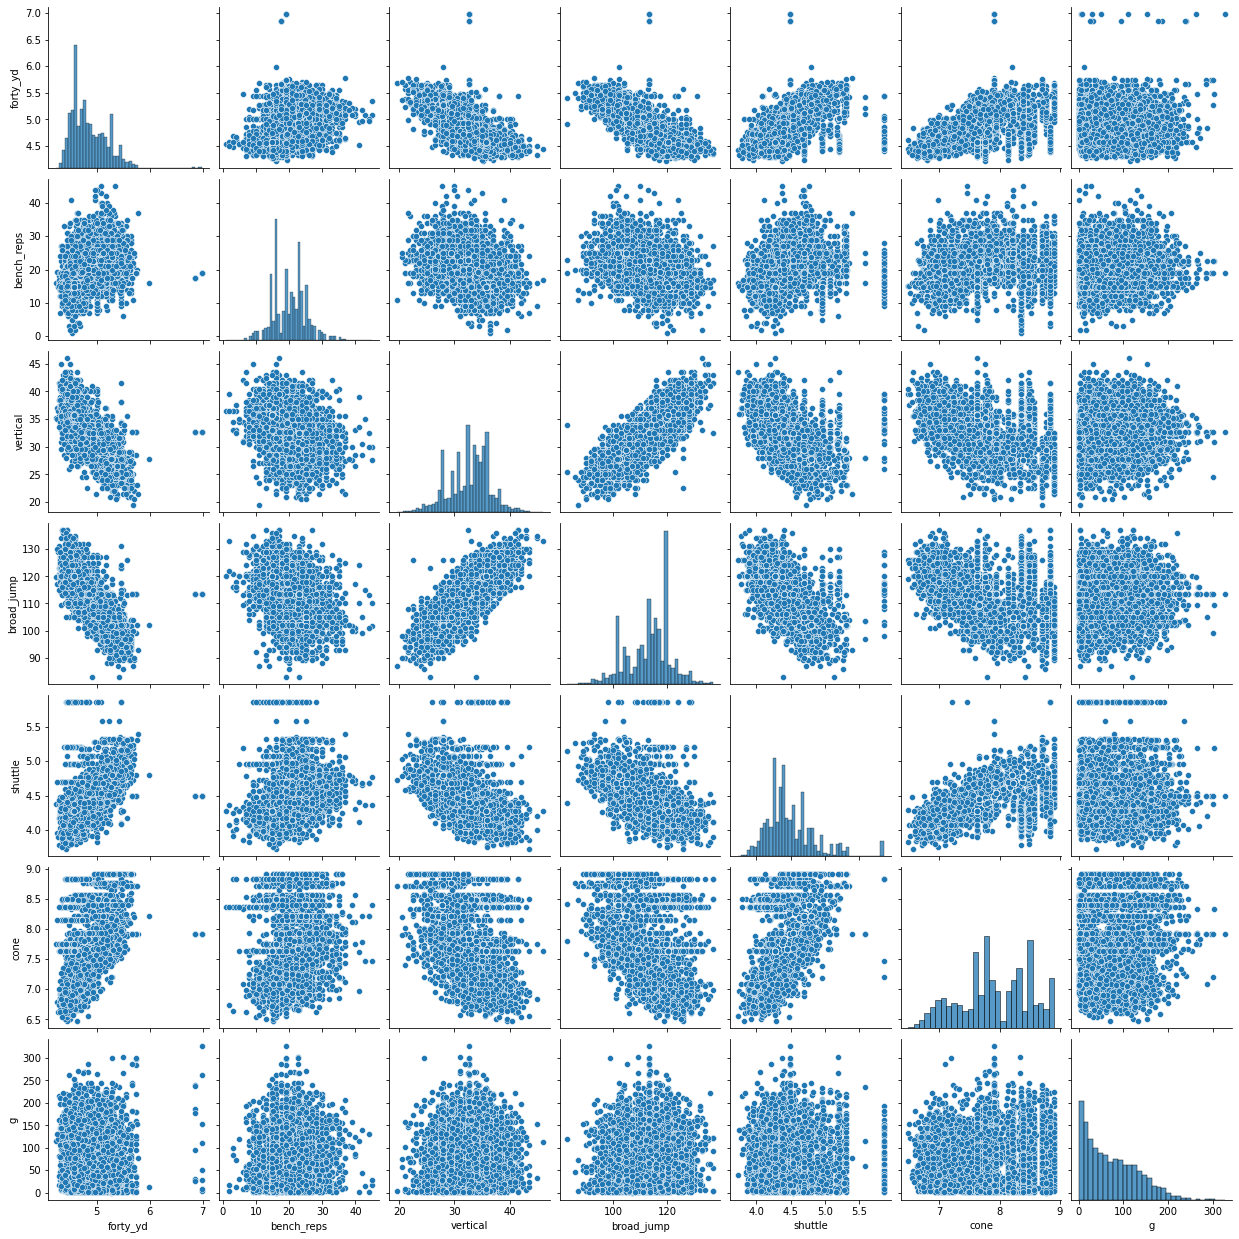

In [799]:
#Pairplot for combine scores - 9.99 scores + NAN resolved
cols = ['forty_yd', 'bench_reps', 'vertical', 'broad_jump', 'shuttle', 'cone', 'g']
sns.pairplot(df2[cols])

In [741]:
df2.describe()

,draft_round,draft_pick,age,g,weight,forty_yd,bench_reps,vertical,broad_jump,shuttle,cone,height,DraftYr,cseasons,cgames,age_group,r1,r2
count,5619.000000,5619.000000,5619.000000,4771.000000,5619.000000,5619.000000,5619.000000,5619.000000,5619.000000,5619.000000,5619.000000,5619.000000,5619.000000,5619.000000,5619.000000,5619.000000,5619.000000,5619.000000
mean,4.619327,131.756718,22.596368,73.830434,241.658246,4.851035,20.166840,32.710735,113.443357,4.585446,7.949455,35.914059,1999.599039,3.038506,33.546902,0.987364,15.172807,15.172807
std,2.518947,78.947895,0.791572,57.901401,44.591402,0.344444,5.209651,3.716604,8.141614,0.778024,0.649388,32.261968,6.233610,0.816120,9.353029,0.111706,11.709350,11.010705
min,1.000000,1.000000,20.000000,0.000000,142.000000,4.220000,1.000000,19.500000,83.000000,3.730000,6.480000,8.216042,1990.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,3.000000,64.000000,22.000000,23.000000,201.000000,4.573463,16.058824,30.000000,108.000000,4.273359,7.580000,8.498364,1994.000000,3.000000,33.000000,1.000000,6.000000,6.500000
50%,5.000000,130.000000,22.747024,63.000000,236.000000,4.761812,20.313901,33.000000,115.000000,4.409577,7.850000,8.833652,2000.000000,3.038506,33.546902,1.000000,12.500000,13.500000
75%,6.000000,196.000000,23.000000,115.000000,277.000000,5.090000,23.000000,35.148492,119.659524,4.696395,8.476090,73.000000,2005.000000,4.000000,38.000000,1.000000,21.500000,21.000000
max,12.000000,335.000000,29.000000,327.000000,387.000000,6.974545,45.000000,46.000000,137.000000,9.990000,9.990000,81.000000,2010.000000,6.000000,61.000000,1.000000,59.500000,61.500000


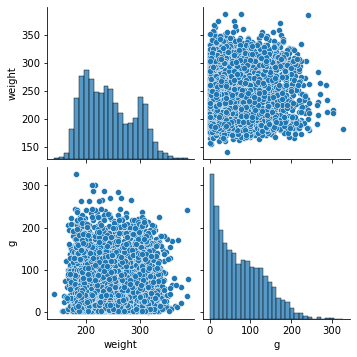

In [800]:
#Pairplot for combine scores - unadjusted
cols = ['weight', 'height', 'g']
sns.pairplot(df[cols])

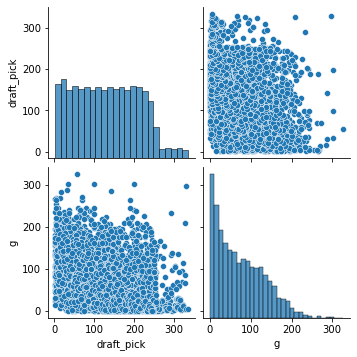

In [777]:
cols = ['draft_pick', 'g']
sns.pairplot(df2[cols], kind='scatter' )

In [518]:
df2.draft_pick.value_counts(dropna=False)


17     35
19     29
206    28
159    28
205    28
       ..
331     2
333     2
332     2
334     1
335     1
Name: draft_pick, Length: 335, dtype: int64

In [519]:
df.g.value_counts(dropna=False)

NaN      848
1.0      100
2.0       85
3.0       76
4.0       73
        ... 
228.0      1
210.0      1
286.0      1
284.0      1
238.0      1
Name: g, Length: 251, dtype: int64

In [604]:
newdf.bench_reps.value_counts(dropna=False)




20.779216    2684
19.000000     201
18.000000     185
22.000000     184
24.000000     179
21.000000     178
23.000000     175
20.000000     171
17.000000     167
25.000000     164
26.000000     135
16.000000     134
15.000000     125
27.000000      95
28.000000      90
14.000000      86
13.000000      81
29.000000      66
12.000000      64
11.000000      61
10.000000      59
30.000000      55
9.000000       46
31.000000      43
33.000000      29
32.000000      29
34.000000      27
8.000000       24
35.000000      20
7.000000       12
37.000000       9
36.000000       9
6.000000        4
4.000000        4
40.000000       3
3.000000        3
2.000000        2
45.000000       2
44.000000       2
42.000000       2
5.000000        2
38.000000       2
39.000000       2
41.000000       2
1.000000        1
43.000000       1
Name: bench_reps, dtype: int64

**** supersimple ***
Features: Index(['draft_pick'], dtype='object')

Training R^2 score was: 0.14130130298114507

Validation R^2 score was: 0.14938244755434493


Lasso Training R^2 score was: 0.14100457831055013

Lasso Validation R^2 score was: 0.1508432847560216


Ridge Training R^2 score was: 0.1413012932827058

Ridge Validation R^2 score was: 0.15113626357774368
Feature coefficient results: 

Feature coefficient results: 

intercept: [108.16112636]
draft_pick : [-0.29306246]


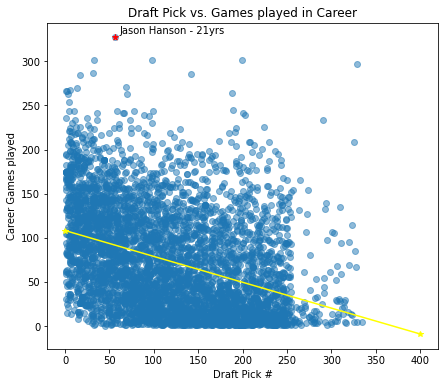

In [950]:
## Run supersimple model and graph

supersimple = df2.copy()
supersimple.dropna(subset=["g"], inplace=True)
X = supersimple[["draft_pick"]]
y = supersimple[["g"]]

split_and_validate(X,y, title = 'supersimple')

plt.figure(figsize=(7,6))
plt.scatter(X, y, alpha = 0.5 );
plt.title("Draft Pick vs. Games played in Career")
plt.xlabel("Draft Pick #")
plt.ylabel("Career Games played")

plt.plot((0, 400),(108.16, 400*(-.293)+108.16), marker='*', color='yellow')
y.g.argmax(), y.g.max()

#supersimple.iloc[545]

plt.scatter(56, 327, color="red", marker="*", )
plt.annotate("Jason Hanson - 21yrs", xy= (56+5,327+5) );
#plt.savefig('Draftpicksimple.png')

In [981]:
# Linear model mutli factor w/poly

newdf = df2.copy()
newdf.shape

newdf.g.fillna(0, inplace=True)


X = newdf[['draft_pick', 'age_group', 
           'forty_yd', 
           'bench_reps',
          'vertical', 'broad_jump', 'shuttle', 'cone']]
y = newdf[['g']]

newdf.shape
#df_train, df_test = train_test_split(new_df, test_size=0.2, random_state=42)
split_and_validate(X,y, title='Linear, multi features')

**** Linear, multi features ***
Features: Index(['draft_pick', 'age_group', 'forty_yd', 'bench_reps', 'vertical',
       'broad_jump', 'shuttle', 'cone'],
      dtype='object')

Training R^2 score was: 0.2234084593347766

Validation R^2 score was: 0.25476379006576133


Lasso Training R^2 score was: 0.22032151693532342

Lasso Validation R^2 score was: 0.25729116472386926


Ridge Training R^2 score was: 0.22340844370704116

Ridge Validation R^2 score was: 0.2617958386821707
Feature coefficient results: 

Feature coefficient results: 

intercept: [37.91813343]
draft_pick : [ -0.35429926  11.58545154  18.9233148    0.22805411   0.4632551
   0.11221561 -16.10621504   1.03806936]


In [991]:
# X, y above with poly
split_and_validate_wpoly(X,y, title='Linear, multi features')

**** Linear, multi features ***

Training R^2 score was: 0.24746439060494307

Validation R^2 score was: 0.2695499641753597


Lasso Training R^2 score was: 0.24067517295364516

Lasso Validation R^2 score was: 0.2914001137986243


Ridge Training R^2 score was: 0.24742467618958908

Ridge Validation R^2 score was: 0.3045655498873896
Feature coefficient results: 

Feature coefficient results: 

intercept: [-1416.84892127]
draft_pick : [ 5.68935804e-10 -4.29923949e-01  1.77134102e+02  2.81989417e+02
  7.25036245e+00 -7.31292003e+00  7.25105407e+00  1.88685757e+02
 -3.99062079e+01  1.20589256e-03 -6.64139421e-02 -3.56024802e-02
  6.89220780e-03 -9.41558228e-04  9.55255890e-04 -5.63775154e-02
  1.28821639e-03  1.77134102e+02 -2.15745784e+01  7.88840342e-01
 -7.78534982e+00  4.24897129e-01 -5.58748774e+00 -2.34983136e+00
 -9.24184550e+00 -1.47480085e+00  9.50134380e-01 -3.37828338e-01
 -3.89171805e+01  9.47399166e+00  3.95408298e-02 -4.18548671e-03
 -2.32281374e-02 -2.03676546e-01  3.22542068e-

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21484.393623461947, tolerance: 1583.621074082311
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1164.6650642729364, tolerance: 407.98580320284697
  model = cd_fast.enet_coordinate_descent(


In [979]:
# Linear model mutli factor w/poly

#Define basedata set - all players, groups, etc. 

#newdf = df.dropna(axis = 0, subset=['g'])
#newdf = df2[df2['position_group'].isin(['WR/DB','Backs','QB','Line'])].copy()
#newdf = df2[df2['position_group'].isin(['WR/DB'])].copy()

newdf = df2.copy()
newdf.shape

schools = newdf.school_name.value_counts(normalize=True)

other_schools = list(schools[schools <= 0.005].index)

newdf['schools_2'] = newdf['school_name']
newdf['schools_2'] = newdf['schools_2'].replace(other_schools, 'Other')

newdf.g.fillna(0, inplace=True)
#newdf.dropna(subset=['g'], inplace=True)

X = newdf[['draft_pick', 'age_group', 
           'forty_yd', 
           'bench_reps',
          'vertical', 'broad_jump', 'shuttle', 'cone',
           'position_group', 'conf','schools_2']]

#'conf', 'school_name',

#X = newdf[['draft_pick', 'age_group', 'conf', 'school_name', 'position_group', 'forty_yd', 'bench_reps']]
X = pd.get_dummies(X, columns = ['position_group', 'conf', 'schools_2'],
                   prefix = ['pos', 'conf', 'sch'], drop_first=True)

#X['position]

y = newdf[['g']]

newdf.shape
#df_train, df_test = train_test_split(new_df, test_size=0.2, random_state=42)
split_and_validate(X,y, title='Linear, multi features, dummies')



**** Linear, multi features, dummies ***
Features: Index(['draft_pick', 'age_group', 'forty_yd', 'bench_reps', 'vertical',
       'broad_jump', 'shuttle', 'cone', 'pos_Kicker', 'pos_Line', 'pos_QB',
       'pos_WR/DB', 'conf_Big 12', 'conf_Big 8', 'conf_Big East',
       'conf_Big Ten', 'conf_Big West', 'conf_CUSA', 'conf_Ind', 'conf_MAC',
       'conf_MWC', 'conf_NotAvailable', 'conf_Pac-10', 'conf_SEC', 'conf_SWC',
       'conf_Sun Belt', 'conf_WAC', 'sch_Arizona', 'sch_Arizona State',
       'sch_Arkansas', 'sch_Auburn', 'sch_California', 'sch_Clemson',
       'sch_Colorado', 'sch_Florida', 'sch_Florida State',
       'sch_Frenso State (CA)', 'sch_Georgia', 'sch_Georgia Tech',
       'sch_Illinois', 'sch_Iowa', 'sch_Kansas State', 'sch_Kentucky',
       'sch_LSU', 'sch_Louisville', 'sch_Maryland', 'sch_Miami (FL)',
       'sch_Michigan', 'sch_Michigan State', 'sch_Mississippi',
       'sch_Mississippi State', 'sch_Nebraska', 'sch_North Carolina',
       'sch_North Carolina State', '

In [999]:
split_and_validate_wpoly(X,y, title='Linear, multi features, dummies')


**** Linear, multi features, dummies ***

Training R^2 score was: 0.24746439060494307

Validation R^2 score was: 0.2695499641753597


Lasso Training R^2 score was: 0.24067517295364516

Lasso Validation R^2 score was: 0.2914001137986243
('1', 0.0)
('x0', -0.0)
('x1', 0.0)
('x2', -0.0)
('x3', -0.0)
('x4', 0.0)
('x5', -0.0)
('x6', 0.0)
('x7', -0.0)
('x0^2', 28.33133454265996)
('x0 x1', -21.07763533324727)
('x0 x2', -18.884826025779216)
('x0 x3', 0.0)
('x0 x4', -10.86676998905364)
('x0 x5', -0.0)
('x0 x6', -0.0)
('x0 x7', -7.318355822354691)
('x1^2', 0.0)
('x1 x2', 0.0)
('x1 x3', 7.507769701252986)
('x1 x4', 0.0)
('x1 x5', 4.587426676926727)
('x1 x6', -1.4427864683690477)
('x1 x7', -0.0)
('x2^2', 19.798667237424272)
('x2 x3', -6.471059106816558)
('x2 x4', 0.0)
('x2 x5', -0.0)
('x2 x6', -12.06982325308065)
('x2 x7', -0.3642685950029831)
('x3^2', -0.5030270555431874)
('x3 x4', -0.0)
('x3 x5', -0.0)
('x3 x6', -0.0)
('x3 x7', -0.0)
('x4^2', -0.0)
('x4 x5', -0.0)
('x4 x6', 0.0)
('x4 x7', 11.083

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21484.393623461947, tolerance: 1583.621074082311
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1164.6650642729364, tolerance: 407.98580320284697
  model = cd_fast.enet_coordinate_descent(


In [989]:
newdf = df2.copy()
newdf["log(g)"] = np.log10(newdf['g']+0.00001)

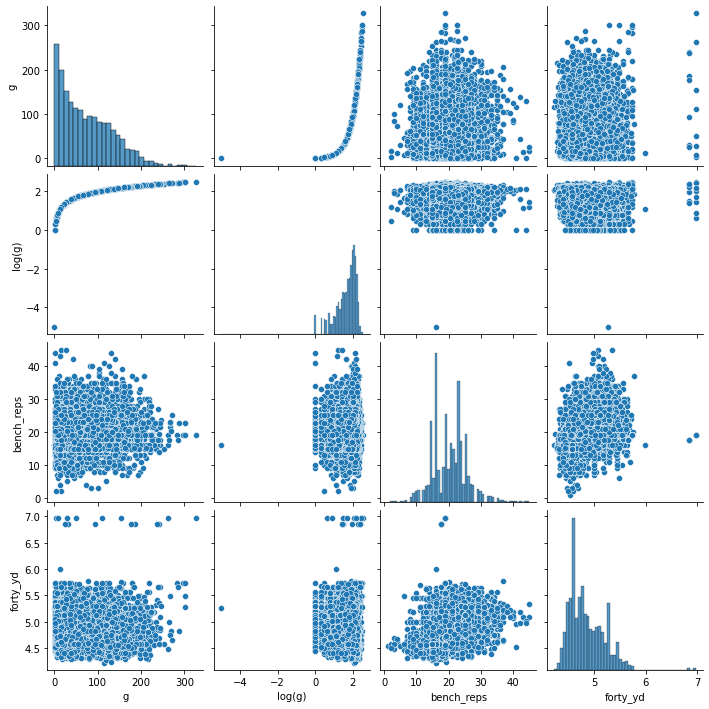

In [990]:
columns = ['g', 'log(g)', 'bench_reps', 'forty_yd']
sns.pairplot(newdf[columns])

In [979]:
# Linear model mutli factor w/poly

#Define basedata set - all players, groups, etc. 

#newdf = df.dropna(axis = 0, subset=['g'])
#newdf = df2[df2['position_group'].isin(['WR/DB','Backs','QB','Line'])].copy()
#newdf = df2[df2['position_group'].isin(['WR/DB'])].copy()

newdf = df2.copy()
newdf.shape

schools = newdf.school_name.value_counts(normalize=True)

other_schools = list(schools[schools <= 0.005].index)

newdf['schools_2'] = newdf['school_name']
newdf['schools_2'] = newdf['schools_2'].replace(other_schools, 'Other')

newdf.g.fillna(0, inplace=True)
#newdf.dropna(subset=['g'], inplace=True)

X = newdf[['draft_pick', 'age_group', 
           'forty_yd', 
           'bench_reps',
          'vertical', 'broad_jump', 'shuttle', 'cone',
           'position_group', 'conf','schools_2']]

#'conf', 'school_name',

#X = newdf[['draft_pick', 'age_group', 'conf', 'school_name', 'position_group', 'forty_yd', 'bench_reps']]
X = pd.get_dummies(X, columns = ['position_group', 'conf', 'schools_2'],
                   prefix = ['pos', 'conf', 'sch'], drop_first=True)

#X['position]

y = newdf[['g']]

newdf.shape
#df_train, df_test = train_test_split(new_df, test_size=0.2, random_state=42)
split_and_validate(X,y, title='Linear, multi features, dummies')



**** Linear, multi features, dummies ***
Features: Index(['draft_pick', 'age_group', 'forty_yd', 'bench_reps', 'vertical',
       'broad_jump', 'shuttle', 'cone', 'pos_Kicker', 'pos_Line', 'pos_QB',
       'pos_WR/DB', 'conf_Big 12', 'conf_Big 8', 'conf_Big East',
       'conf_Big Ten', 'conf_Big West', 'conf_CUSA', 'conf_Ind', 'conf_MAC',
       'conf_MWC', 'conf_NotAvailable', 'conf_Pac-10', 'conf_SEC', 'conf_SWC',
       'conf_Sun Belt', 'conf_WAC', 'sch_Arizona', 'sch_Arizona State',
       'sch_Arkansas', 'sch_Auburn', 'sch_California', 'sch_Clemson',
       'sch_Colorado', 'sch_Florida', 'sch_Florida State',
       'sch_Frenso State (CA)', 'sch_Georgia', 'sch_Georgia Tech',
       'sch_Illinois', 'sch_Iowa', 'sch_Kansas State', 'sch_Kentucky',
       'sch_LSU', 'sch_Louisville', 'sch_Maryland', 'sch_Miami (FL)',
       'sch_Michigan', 'sch_Michigan State', 'sch_Mississippi',
       'sch_Mississippi State', 'sch_Nebraska', 'sch_North Carolina',
       'sch_North Carolina State', '

In [1001]:
def split_and_validate(X, y, title=None):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
     
    # score fit model on validation data
    train_score = lr_model.score(X_train, y_train)
        
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    ss = StandardScaler()
    ss.fit(X_train.values)
    scaled_X_tr = ss.transform(X_train.values)
    scaled_X_val = ss.transform(X_val.values)
    
    lasso = Lasso(alpha=1, max_iter=1000 )
    lasso.fit(scaled_X_tr, y_train)
    lasso_train_score = lasso.score(scaled_X_tr, y_train) 

    lasso = Lasso(alpha=1, max_iter=1000 )
    lasso.fit(scaled_X_val, y_val)
    lasso_val_score = lasso.score(scaled_X_val, y_val)     
    
    ridge = Ridge(alpha=1, max_iter=1000 )
    ridge.fit(scaled_X_tr, y_train)
    ridge_train_score = ridge.score(scaled_X_tr, y_train) 

    ridge = Ridge(alpha=1, max_iter=1000 )
    ridge.fit(scaled_X_val, y_val)
    ridge_val_score = ridge.score(scaled_X_val, y_val) 
    
    # report results
    if title:
        print(f"**** {title} ***")
    print(f'Features: {X_train.columns}')
    
    print('\nTraining R^2 score was:', train_score)
    print('\nValidation R^2 score was:', val_score)
    print()
    print('\nLasso Training R^2 score was:', lasso_train_score)
    print('\nLasso Validation R^2 score was:', lasso_val_score)    
    print()
    print('\nRidge Training R^2 score was:', ridge_train_score)
    print('\nRidge Validation R^2 score was:', ridge_val_score)    
    print('Feature coefficient results: \n')
    
    print('Feature coefficient results: \n')
    print("intercept: {}".format(lr_model.intercept_))
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', coef) 
    
    

In [1014]:
def split_and_validate_wpoly(X, y, title=None):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    
    poly = PolynomialFeatures()
    poly.fit(X_train)
    
    lr_model.fit(poly.transform(X_train), y_train)
    poly_X_train = poly.transform(X_train)
    poly_X_val = poly.transform(X_val)
    
    # score fit model on validation data
    train_score = lr_model.score(poly_X_train, y_train)
        
    # score fit model on validation data
    val_score = lr_model.score(poly_X_val, y_val)
    
    ss = StandardScaler()
    ss.fit(poly_X_train)
    scaled_X_tr = ss.transform(poly_X_train)
    scaled_X_val = ss.transform(poly_X_val)
    
    alpha = 1.25
    
    lasso = Lasso(alpha=alpha, max_iter=1000 )
    lasso.fit(scaled_X_tr, y_train)
    lasso_train_score = lasso.score(scaled_X_tr, y_train) 

    lasso = Lasso(alpha=alpha, max_iter=1000 )
    lasso.fit(scaled_X_val, y_val)
    lasso_val_score = lasso.score(scaled_X_val, y_val)     
    
    ridge = Ridge(alpha=alpha, max_iter=1000 )
    ridge.fit(scaled_X_tr, y_train)
    ridge_train_score = ridge.score(scaled_X_tr, y_train) 

    ridge = Ridge(alpha=alpha, max_iter=1000 )
    ridge.fit(scaled_X_val, y_val)
    ridge_val_score = ridge.score(scaled_X_val, y_val) 
    
    # report results
    if title:
        print(f"**** {title} ***")
    
    print('\nTraining R^2 score was:', train_score)
    print('\nValidation R^2 score was:', val_score)
    print()
    print('\nLasso Training R^2 score was:', lasso_train_score)
    print('\nLasso Validation R^2 score was:', lasso_val_score)    
    for a in zip(poly.get_feature_names(),lasso.coef_):
        print(a)
    print()
    print('\nRidge Training R^2 score was:', ridge_train_score)
    print('\nRidge Validation R^2 score was:', ridge_val_score)    
    print('Feature coefficient results: \n')
    
    print('Feature coefficient results: \n')
    print("intercept: {}".format(lr_model.intercept_))
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', coef) 
    
    

In [1047]:
def split_and_validate_wpoly_LR_CV(X, y, title=None):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 1000)
    kfr2 = np.mean(cross_val_score(lr_model, X_train, y_train, cv=kf, scoring='r2'))
        
    poly = PolynomialFeatures()
    poly.fit(X_train)
    
    lr_model.fit(poly.transform(X_train), y_train)
    poly_X_train = poly.transform(X_train)
    poly_X_val = poly.transform(X_val)
    
    # score fit model on validation data
    train_score = lr_model.score(poly_X_train, y_train)
        
    # score fit model on validation data
    val_score = lr_model.score(poly_X_val, y_val)
    
    ss = StandardScaler()
    ss.fit(poly_X_train)
    scaled_X_tr = ss.transform(poly_X_train)
    scaled_X_val = ss.transform(poly_X_val)
    
    alphavec = 10**np.linspace(-2,2,200)

    lasso = LassoCV(alphas = alphavec, cv=5)
    lasso.fit(scaled_X_tr, y_train)
    
    lasso_train_score = lasso.score(scaled_X_tr, y_train) 

    lasso.fit(scaled_X_val, y_val)
    lasso_val_score = lasso.score(scaled_X_val, y_val)     

    ridge = RidgeCV(alphas = alphavec, cv=5)
    ridge.fit(scaled_X_tr, y_train)
    
    ridge_train_score = ridge.score(scaled_X_tr, y_train) 

    ridge.fit(scaled_X_val, y_val)
    ridge_val_score = ridge.score(scaled_X_val, y_val)     
    
#     ridge = Ridge(alpha=1, max_iter=1000 )
#     ridge.fit(scaled_X_tr, y_train)
#     ridge_train_score = ridge.score(scaled_X_tr, y_train) 

#     ridge = Ridge(alpha=1, max_iter=1000 )
#     ridge.fit(scaled_X_val, y_val)
#     ridge_val_score = ridge.score(scaled_X_val, y_val) 
    
    # report results
    if title:
        print(f"**** {title} ***")
    
    print('\nKFold Training R^2 score was:', kfr2)
    print('\nTesting R^2 score was:', val_score)
    print()
    print('\nLassoCV Training R^2 score was:', lasso_train_score)
    print('\nLassoCV Testing R^2 score was:', lasso_val_score)    
    
    print(f'optimum alpha {lasso.alpha_}')
    print("Coefficients using best alpha")
    for a in zip(poly.get_feature_names(), lasso.coef_):
        print(a)
    
    print()
    print('\nRidgeCV Training R^2 score was:', ridge_train_score)
    print('\nRidgeCV Testing R^2 score was:', ridge_val_score)    
    print('Feature coefficient results: \n')
    
    print(f'optimum alpha {ridge.alpha_}')
    print("Coefficients using best alpha")
    for a in zip(poly.get_feature_names(), ridge.coef_):
        print(a)

    print("intercept: {}".format(lr_model.intercept_))
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', coef) 
    
    generate_lars_path(X_train, y_train)
    

In [1013]:
split_and_validate(X,y, title='Linear, multi features')

**** Linear, multi features ***
Features: Index(['draft_pick', 'age_group', 'forty_yd', 'bench_reps', 'vertical',
       'broad_jump', 'shuttle', 'cone'],
      dtype='object')

Training R^2 score was: 0.2234084593347766

Validation R^2 score was: 0.25476379006576133


Lasso Training R^2 score was: 0.22032151693532342

Lasso Validation R^2 score was: 0.25729116472386926


Ridge Training R^2 score was: 0.22340844370704116

Ridge Validation R^2 score was: 0.2617958386821707
Feature coefficient results: 

Feature coefficient results: 

intercept: [37.91813343]
draft_pick : [ -0.35429926  11.58545154  18.9233148    0.22805411   0.4632551
   0.11221561 -16.10621504   1.03806936]


In [1048]:
#split_and_validate_wpoly(X,y, title = 'Polynomial Features')
split_and_validate_wpoly_LR_CV(X,y, title = 'Polynomial Features')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2349.3980543296784, tolerance: 1272.0770848442717
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3270.5582441724837, tolerance: 1272.0770848442717
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:52

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1646.072117542848, tolerance: 1262.2941128754176
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1632.9859811905771, tolerance: 1262.2941128754176
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1764.1437654923648, tolerance: 1262.2941128754176
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sk

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2306.4716602303088, tolerance: 1282.7863894048935
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2085.1710021141917, tolerance: 1282.7863894048935
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2199.692068973556, tolerance: 1282.7863894048935
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sk

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1231437.6040195823, tolerance: 1583.621074082311
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 397.5073846443556, tolerance: 318.8624447163515
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Conve

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369.1563765015453, tolerance: 326.61911568409346
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 468.82085533393547, tolerance: 326.61911568409346
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 410.9142101840116, tolerance: 326.61911568409346
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/skl

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115144.88970866892, tolerance: 317.5697748609566
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117563.91732332273, tolerance: 317.5697748609566
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117931.05737840733, tolerance: 317.5697748609566
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/skle

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40137.457656412385, tolerance: 328.0857639999999
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50668.731295062695, tolerance: 328.0857639999999
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65129.38894149568, tolerance: 328.0857639999999
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklea

**** Polynomial Features ***

KFold Training R^2 score was: 0.21627381796082004

Testing R^2 score was: 0.2695499641753597


LassoCV Training R^2 score was: 0.24452255522674782

LassoCV Testing R^2 score was: 0.2891905911476942
optimum alpha 0.16831803533309567
Coefficients using best alpha
('1', 0.0)
('x0', -0.0)
('x1', 0.0)
('x2', 0.0)
('x3', -0.0)
('x4', 0.0)
('x5', -0.0)
('x6', -0.0)
('x7', -0.0)
('x0^2', 26.66398772819984)
('x0 x1', -21.458502818962195)
('x0 x2', -13.070012569390572)
('x0 x3', -0.0)
('x0 x4', -10.115957763773077)
('x0 x5', -0.0)
('x0 x6', -0.0)
('x0 x7', -11.665695796450214)
('x1^2', 0.0)
('x1 x2', 4.676552550654463)
('x1 x3', 0.8135850478880654)
('x1 x4', 2.249339339262488)
('x1 x5', 0.0)
('x1 x6', -0.0)
('x1 x7', -0.0)
('x2^2', 13.51480217378479)
('x2 x3', -0.0)
('x2 x4', 2.1739209495134797)
('x2 x5', -0.0)
('x2 x6', -12.8988278866216)
('x2 x7', -0.0)
('x3^2', -0.0)
('x3 x4', 0.0)
('x3 x5', -0.0)
('x3 x6', -0.0)
('x3 x7', -0.0)
('x4^2', 0.0)
('x4 x5', -0.0)
('x4

ValueError: non-broadcastable output operand with shape (7,1) doesn't match the broadcast shape (7,7)

In [835]:
lm = LinearRegression()
lm.fit(X,y)
yhat_lm = lm.predict(X)
print("LinearRegression TRAIN\t R2: {:.2f}".format(lm.score(X,y)))
#print("LinearRegression TRAIN\t R2: {:.2f}".format(lm.score(X,y)))

dm = DummyRegressor(strategy = 'median')
dm.fit(X,y)
yhat_dm_median = dm.predict(X)
print("DummyRegression (median)\t R2: {:.2f}".format(dm.score(X,y)))

dm = DummyRegressor()   #default strategy is 'mean'
dm.fit(X,y)
yhat_dm_mean = dm.predict(X)
print("DummyRegression (mean)\t\t R2: {:.2f}".format(dm.score(X,y)))


LinearRegression TRAIN	 R2: 0.23
DummyRegression (median)	 R2: -0.07
DummyRegression (mean)		 R2: 0.00


(5619, 1)
[[ 20.45599989]
 [-40.79531625]
 [ 70.75731287]
 ...
 [ 34.02878368]
 [ 46.64238568]
 [ 11.5333117 ]]


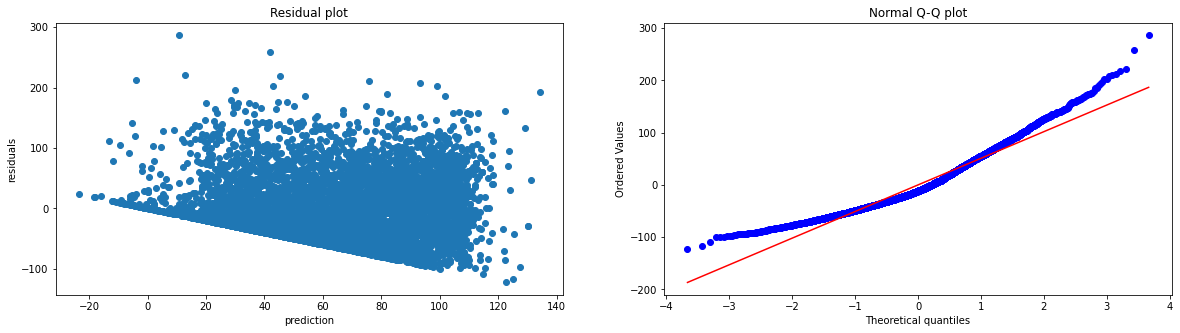

In [1049]:
diagnostic_plot1(y.values, yhat_lm)

In [1039]:
from sklearn.linear_model import lars_path

def generate_lars_path(X_train, y_train):
    ## Scale the variables
    std = StandardScaler()
    std.fit(X_train.values)

    X_tr = std.transform(X_train.values)

    ## Note: lars_path takes numpy matrices, not pandas dataframes

    print("Computing regularization path using the LARS ...")
    alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

    # plotting the LARS path

    xx = np.sum(np.abs(coefs.T), axis=1)
    xx /= xx[-1]

    plt.figure(figsize=(10,10))
    plt.plot(xx, coefs.T)
    ymin, ymax = plt.ylim()
    plt.vlines(xx, ymin, ymax, linestyle='dashed')
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title('LASSO Path')
    plt.axis('tight')
    plt.legend(X_train.columns)
    plt.show()



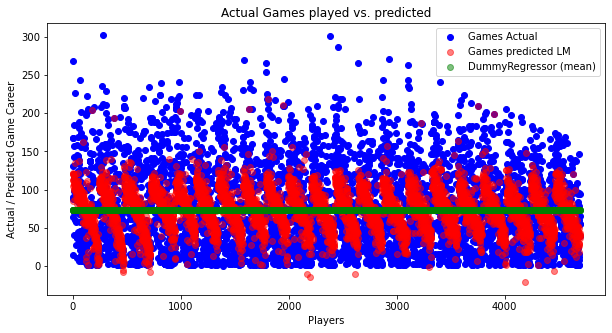

In [101]:
plt.figure(figsize=(10,5))
plt.scatter(range(len(y)), y, color="blue")
plt.scatter(range(len(yhat_lm)), yhat_lm, color ="red", alpha = 0.5)
plt.scatter(range(len(yhat_dm_mean)), yhat_dm_mean, color ="green", alpha = 0.5)
plt.xlabel("Players")
plt.ylabel("Actual / Predicted Game Career");
plt.title("Actual Games played vs. predicted")
plt.legend(['Games Actual','Games predicted LM', 'DummyRegressor (mean)']);
#plt.plot(range(300),range(300), color='red')
#plt.savefig('actualvpredicted-nfl.png');

In [397]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

lm = LinearRegression()
lm.fit(X_poly, y)
yhat_poly = lm.predict(X_poly)
print("Linear Regression Poly TRAIN\t R2: {:.2f}".format(lm.score(X_poly,y)))
#print("LinearRegression TRAIN\t R2: {:.2f}".format(lm.score(X,y)))
print(list(zip(poly.get_feature_names(), lm.coef_)))

Linear Regression Poly TRAIN	 R2: 0.70
[('1', array([-8.08152083e+10, -8.55551401e+06, -2.10785683e+10, ...,
       -6.55756744e+08,  0.00000000e+00, -1.89315433e+08]))]


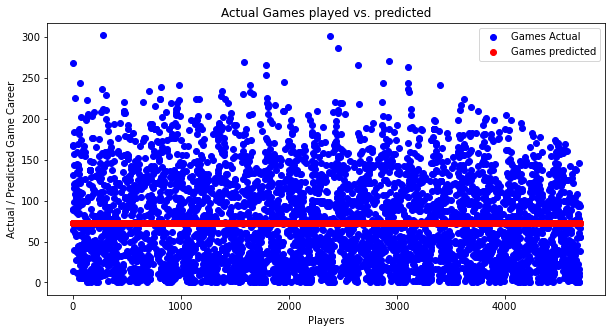

In [137]:
plt.figure(figsize=(10,5))
plt.scatter(range(len(y)), y, color="blue")
plt.scatter(range(len(yhat)), yhat, color ="red")
plt.xlabel("Players")
plt.ylabel("Actual / Predicted Game Career");
plt.title("Actual Games played vs. predicted")
plt.legend(['Games Actual','Games predicted']);

In [105]:
df2.corr()[['g']]

,g
draft_round,-0.360903
draft_pick,-0.378522
age,-0.199593
g,1.000000
weight,0.054131
forty_yd,0.006185
bench_reps,0.045936
vertical,0.024690
broad_jump,0.018738
shuttle,-0.008858


<AxesSubplot:>

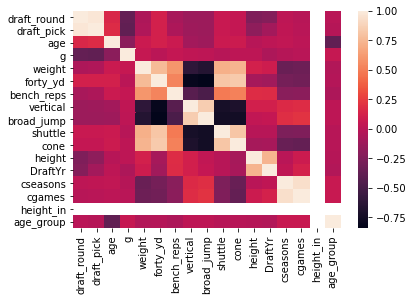

In [106]:
sns.heatmap(df2.corr())

In [810]:
lasso = Lasso(alpha=0.1, max_iter=1000 )
ss = StandardScaler()
ss.fit_transform(X_poly)
lasso.fit(X_poly,y)
lasso.score(X_poly,y)

ValueError: Found input variables with inconsistent numbers of samples: [2155, 5619]

In [393]:
list(zip(X_poly.columns, lasso_model.coef_))

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [133]:
df2.g.value_counts(dropna = False)

NaN      848
1.0      100
2.0       85
3.0       76
4.0       73
        ... 
228.0      1
210.0      1
286.0      1
284.0      1
238.0      1
Name: g, Length: 251, dtype: int64

In [ ]:
df['g_fillna0'] = df.g.fillna(0)

In [ ]:
y = df['g_fillna0']

In [ ]:
x = df[['age_dropna', 'draft_pick', 'draft_round']]

In [ ]:
lm = LinearRegression()

In [ ]:
lm.fit(x, y)

In [ ]:
yhat = lm.predict(x)

In [ ]:
r2_score(y.values, yhat)

ValueError: could not broadcast input array from shape (4699) into shape (1)

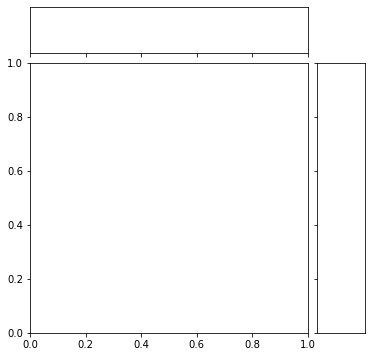

In [121]:
sns.jointplot(x=yhat,y=y, kind='reg')